<>:19: SyntaxWarning: invalid escape sequence '\s'
<>:19: SyntaxWarning: invalid escape sequence '\s'
C:\Users\user\AppData\Local\Temp\ipykernel_14840\4147977517.py:19: SyntaxWarning: invalid escape sequence '\s'
  raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)


CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
target     0
dtype: int64


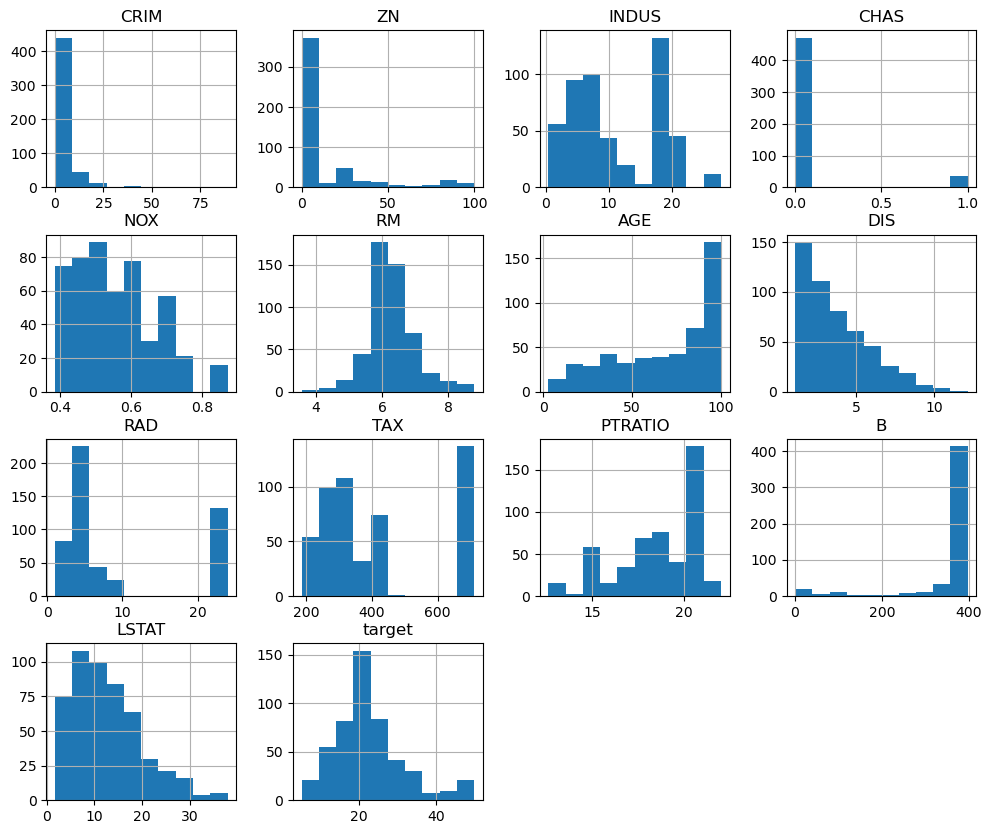

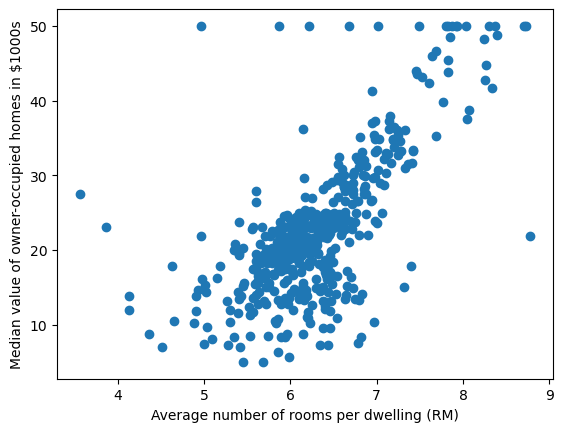

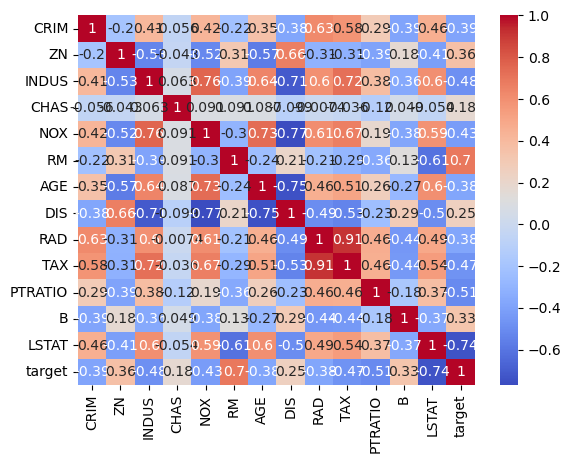

Best hyperparameters for Random Forest: {'max_depth': 26, 'min_samples_split': 2, 'n_estimators': 197}
Best score for Random Forest: -14.987647864525815
                          MAE        MSE      RMSE        R2
Simple LR            4.478336  46.144775  6.792995  0.370757
Multiple LR          3.189092  24.291119  4.928602  0.668759
Polynomial LR        2.587930  14.183558  3.766107  0.806589
Ridge                3.132947  24.477191  4.947443  0.666222
Lasso                3.145240  25.155594  5.015535  0.656971
SVR                  3.140423  29.435702  5.425468  0.598607
Decision Tree        2.458824  10.539020  3.246386  0.856287
Random Forest        2.078284   9.445953  3.073427  0.871192
Tuned Random Forest  2.039305   8.534362  2.921363  0.883623


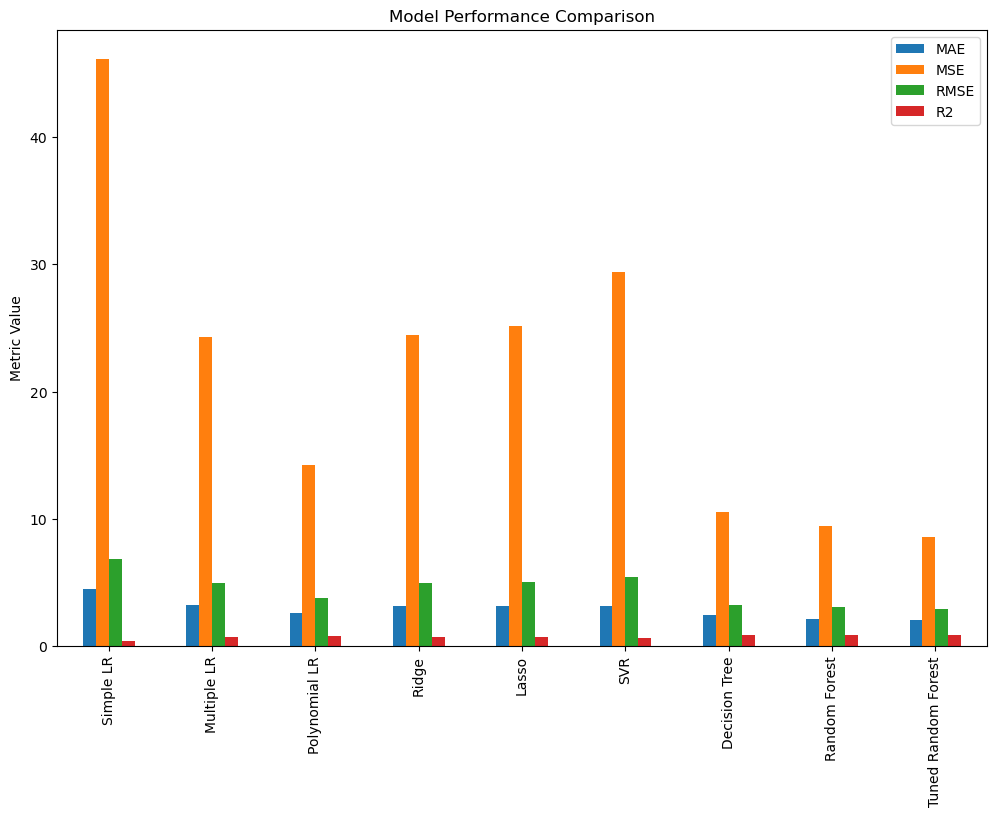

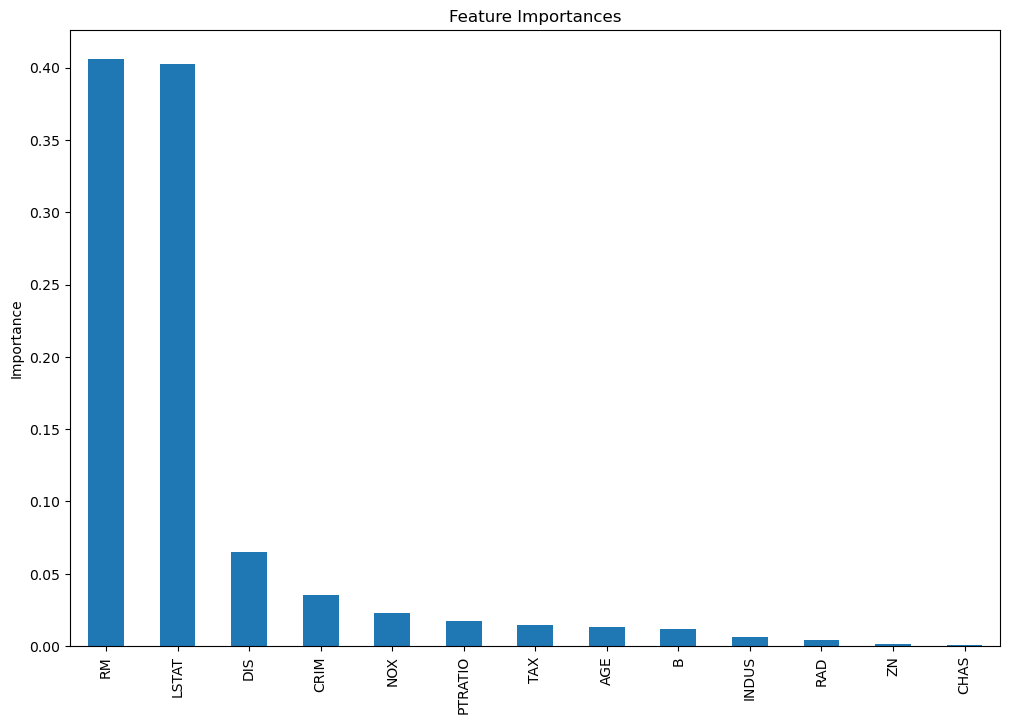

In [7]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import randint


# Load data
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]
X = data
y = target

# Check for missing values
feature_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
df = pd.DataFrame(X, columns=feature_names)
df['target'] = y
print(df.isnull().sum())

# Visualize the data using histograms
df.hist(figsize=(12, 10))
plt.show()

# Visualize the data using scatter plots
plt.scatter(df['RM'], df['target'])
plt.xlabel('Average number of rooms per dwelling (RM)')
plt.ylabel('Median value of owner-occupied homes in $1000s')
plt.show()

# Visualize the data using a correlation matrix heatmap
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Evaluation function
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    return mae, mse, rmse, r2

# Implement Simple Linear Regression
simple_lr = LinearRegression()
simple_lr.fit(X_train[:, np.newaxis, 5], y_train)
simple_lr_metrics = evaluate_model(simple_lr, X_test[:, np.newaxis, 5], y_test)

# Implement Multiple Linear Regression
multiple_lr = LinearRegression()
multiple_lr.fit(X_train, y_train)
multiple_lr_metrics = evaluate_model(multiple_lr, X_test, y_test)

# Implement Polynomial Regression 
poly_features = PolynomialFeatures(degree=2)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)
poly_lr = LinearRegression()
poly_lr.fit(X_train_poly, y_train)
poly_lr_metrics = evaluate_model(poly_lr, X_test_poly, y_test)

# Implement Ridge Regression
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
ridge_metrics = evaluate_model(ridge, X_test, y_test)

# Implement Lasso Regression
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)
lasso_metrics = evaluate_model(lasso, X_test, y_test)

# Implement Support Vector Regression
svr = SVR(kernel='linear', C=1.0)
svr.fit(X_train, y_train)
svr_metrics = evaluate_model(svr, X_test, y_test)

# Implement Decesion Tree Regression
dtree = DecisionTreeRegressor()
dtree.fit(X_train, y_train)
dtree_metrics = evaluate_model(dtree, X_test, y_test)

# Implement Random Forest regression
rforest = RandomForestRegressor(n_estimators=100)
rforest.fit(X_train, y_train)
rforest_metrics = evaluate_model(rforest, X_test, y_test)

param_dist = {
    'n_estimators': randint(10, 200),
    'max_depth': randint(1, 30),
    'min_samples_split': randint(2, 10)
}

rforest = RandomForestRegressor(random_state=42)
random_search = RandomizedSearchCV(estimator=rforest, param_distributions=param_dist, n_iter=50, cv=5, scoring='neg_mean_squared_error', random_state=42)
random_search.fit(X_train, y_train)

print("Best hyperparameters for Random Forest:", random_search.best_params_)
print("Best score for Random Forest:", random_search.best_score_)

# Retrain the model with the best hyperparameters
best_rforest = random_search.best_estimator_
best_rforest.fit(X_train, y_train)
best_rforest_metrics = evaluate_model(best_rforest, X_test, y_test)

# Collect the evaluation metrics for each model in a DataFrame
model_names = ['Simple LR', 'Multiple LR', 'Polynomial LR', 'Ridge', 'Lasso', 'SVR', 'Decision Tree', 'Random Forest', 'Tuned Random Forest']
metrics_list = [simple_lr_metrics, multiple_lr_metrics, poly_lr_metrics, ridge_metrics, lasso_metrics, svr_metrics, dtree_metrics, rforest_metrics, best_rforest_metrics]

results = pd.DataFrame(metrics_list, columns=['MAE', 'MSE', 'RMSE', 'R2'], index=model_names)
print(results)

# Visualize the performance of each moddel using a bar plot
results.plot(kind='bar', figsize=(12, 8), ylabel='Metric Value', title='Model Performance Comparison')
plt.show()

# Select the best model
best_model = best_rforest

# Fit the best model on the entire dataset
best_model.fit(X, y)

# Analyze feature importances for the Random Forest model
importances = best_model.feature_importances_
feature_importances = pd.Series(importances, index=feature_names)
feature_importances.sort_values(ascending=False).plot(kind='bar', figsize=(12, 8), ylabel='Importance', title='Feature Importances')
plt.show()